# Fish Identification Model

The goal of this notebook is to create a neural network model which is capable of identify a variety of freshwater fish spieces. This work is based on what was taught in lesson 1 of the fast.ai course-v3.

### Prepare Notebook
Start by setting up the notebook and importing the fast.ai libraries. Although importing * is typically not good practice for production, it works well for speed of exploration when trying to develop a model.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.vision import *

## Step One: Import & Review the Data

First we need to create a python path variable that hold the location of our dataset and then create an `ImageDataBunch` from it. Once we have the data imported, we'll quickly review the data to assess the data integrity.

In [3]:
data_path = Path('./train_data/')

In [16]:
data = ImageDataBunch.from_folder(path=data_path, valid_pct=0.1, ds_tfms=get_transforms(), size=244).normalize()

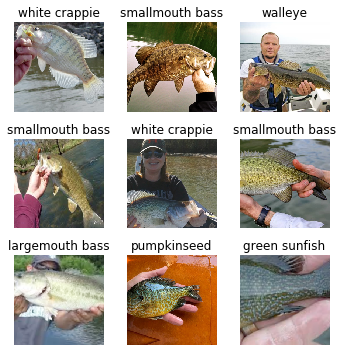

In [17]:
data.show_batch(rows=3, figsize=(5,5))

Looking at the imported pictures, everything seems to have come in correctly labelled. The cropping to make them all square seems to have cut off a number of heads/tails, but we'll run with it for now to see what we can make of it. Depending on the performance we may come back and tweak this step.

In [18]:
data.classes

['black crappie',
 'bluegill',
 'green sunfish',
 'largemouth bass',
 'pumpkinseed',
 'redear sunfish',
 'rock bass',
 'smallmouth bass',
 'walleye',
 'white crappie',
 'yellow perch']

In [19]:
data.c

11

## Step 2: Import and Train a Model

In this step we'll start with a Resnet 34 model pre-trained on ImageNet. We'll start with a 34 in favor of 50 initially since it runs & trains faster so we can iterate and explore faster.

In [28]:
learner = cnn_learner(data, models.resnet34, metrics=[error_rate])

In [29]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.650018,3.854649,0.848485,00:06
1,2.812764,1.583838,0.393939,00:07
2,2.207993,1.085346,0.363636,00:08
3,1.815737,0.960656,0.333333,00:07


#### First Try:
hmm... doesn't look great so far...
Double checking against the Lesson 1 Notebook, we it appears we forgot to normalize & do any transforms to our images. Lets add that in and try again.

#### Second Try:
A little better, the error rate seems to be dropping a little more consistently this time, but I think we need to train further. Lets see what happens.

In [30]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.746237,0.890365,0.272727,00:08
1,0.725181,0.791985,0.212121,00:08
2,0.622107,0.730318,0.212121,00:08
3,0.543649,0.686221,0.181818,00:09
4,0.483379,0.662257,0.181818,00:07
5,0.444539,0.640107,0.151515,00:06
6,0.418338,0.645691,0.151515,00:07
7,0.384355,0.637721,0.151515,00:06


Looks like we've maxed out at around 85% accurate for now. Lets have a quick look to see how we're doing.
## Step 3: Analyze out current results

Let start by having a look at the confusion matrix to see if we can pick out anything there.

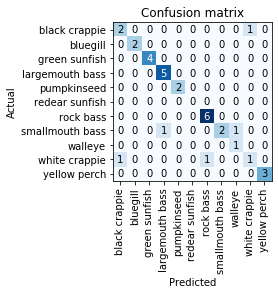

In [31]:
results = ClassificationInterpretation.from_learner(learner)
results.plot_confusion_matrix()

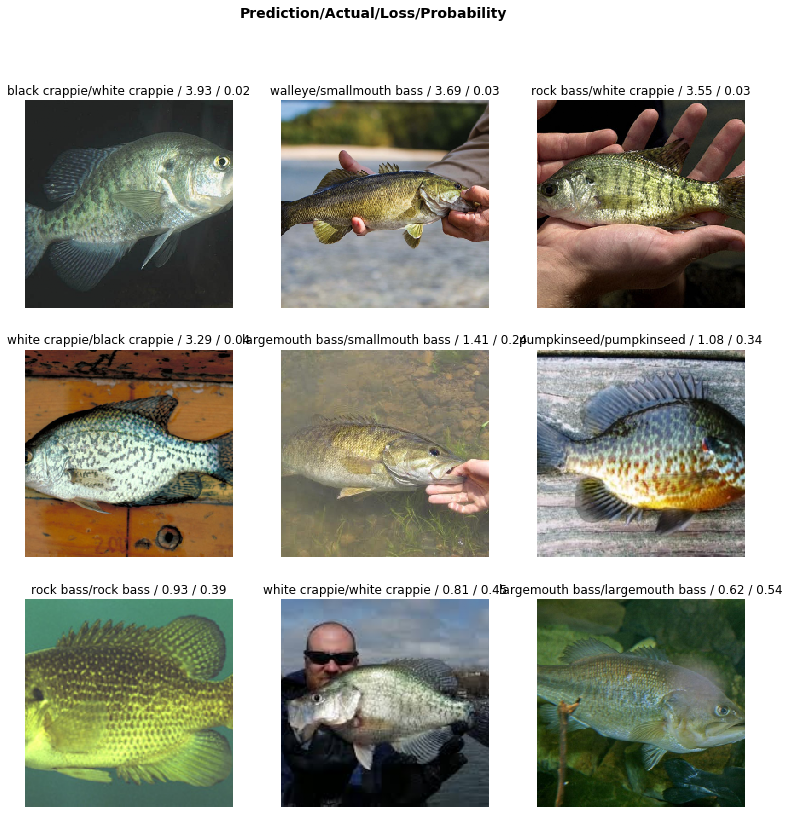

In [37]:
results.plot_top_losses(9, figsize=(13,13))

In [38]:
results.most_confused()

[('black crappie', 'white crappie', 1),
 ('smallmouth bass', 'largemouth bass', 1),
 ('smallmouth bass', 'walleye', 1),
 ('white crappie', 'black crappie', 1),
 ('white crappie', 'rock bass', 1)]

It looks like there is the most confusion between black and white crappie, which frankly can be pretty hard for even the average person to tell apart just by sight. (The most accurate way to distinguish is by counting dorsal spines) Overall, that looks pretty good for some quick and dirty rough work. Lets see if we can fine-tune it all.

## Step 4: Fine Tuning

We're going to unfreeze the pretrained weights so the whole model can be trained, but we probably don't want to train it as fast as we did when training just the randomized head, so we'll check that. Also don't forget to save our progress!

In [39]:
learner.save('fish-id-res34-step1')

In [41]:
learner.unfreeze()
learner.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.237803,0.692908,0.242424,00:17
1,0.289714,0.934799,0.242424,00:11


Yup, the losses got worse. We're probably training too fast now. Lets reset and look at the learning rate.

In [45]:
learner.load('fish-id-res34-step1')
learner.lr_find();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


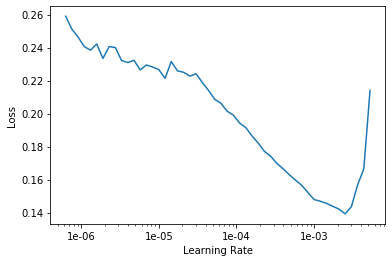

In [46]:
learner.recorder.plot()

It looks like our best learning rate would be in the range of 1e-4 to 3e-3.

In [48]:
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(1e-4, 2e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.242916,0.651861,0.212121,00:06
1,0.278585,0.702532,0.151515,00:06


Well, it's better than letting the training run wild, but isn't a major improvement over the coarse training yet. Lets, give it a few more epochs to see what it can do.

In [49]:
learner.fit_one_cycle(8, max_lr=slice(1e-4, 2e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.273438,0.614634,0.121212,00:05
1,0.195434,0.670845,0.151515,00:06
2,0.226340,0.659592,0.212121,00:05
3,0.211702,1.222739,0.242424,00:06
4,0.189771,1.225884,0.242424,00:06
5,0.185314,1.017031,0.212121,00:05
6,0.175978,0.749706,0.212121,00:05
7,0.158035,0.677474,0.181818,00:05


Still no real significant improvement over where the coarse training took us. We can still look at increasing the network size to say a ResNet50 or even larger, and possibly revisiting how our data is cropped to see if we can not cut-off the heads & tails as much. Also given the fairly large difference between our train & validation losses and the small size of our dataset, we may be overfitting a little too. Maybe I can find a few more fish pictures to test on as a test set... to be continued.

## Step 5 Lets try a larger model

This time lets try a larger model. We'll also try bumping up the image size a little to give it a few more pixels to work with.

List of Classes:  ['black crappie', 'bluegill', 'green sunfish', 'largemouth bass', 'pumpkinseed', 'redear sunfish', 'rock bass', 'smallmouth bass', 'walleye', 'white crappie', 'yellow perch']
Number of Classes:  11


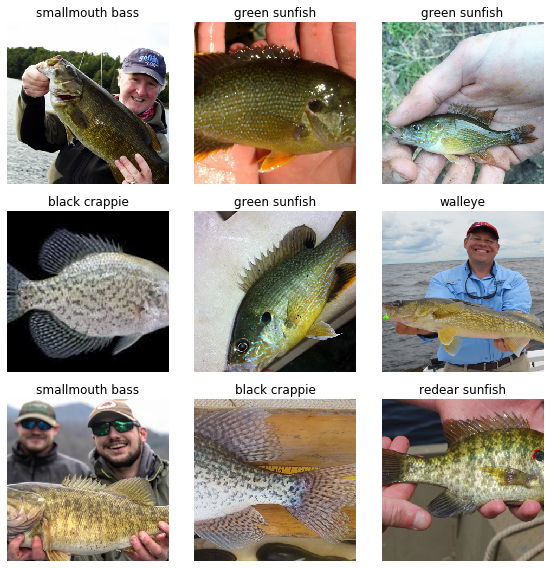

In [4]:
data_path = Path('./train_data/')
data = ImageDataBunch.from_folder(path=data_path, valid_pct=0.1, ds_tfms=get_transforms(), size=299, bs=32).normalize()
data.show_batch(rows=3, figsize=(8,8))
print("List of Classes: ",data.classes)
print("Number of Classes: ", data.c)

In [5]:
learner = cnn_learner(data, models.resnet50, metrics=[error_rate])
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.748690,2.375740,0.666667,00:09
1,1.731558,0.997681,0.363636,00:06
2,1.300902,0.858828,0.272727,00:06
3,1.029773,0.873457,0.242424,00:06


In [8]:
learner.save('fish-id-res50-step1')
learner.lr_find()
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


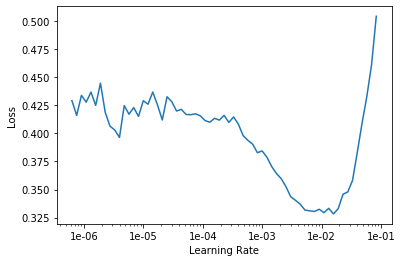

In [9]:
learner.recorder.plot()

In [10]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.409050,1.213022,0.303030,00:07
1,0.460839,1.984118,0.333333,00:06
2,0.485814,1.115884,0.242424,00:07
3,0.418093,0.829792,0.272727,00:07


In [11]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.180057,0.860103,0.212121,00:07
1,0.206157,1.459731,0.272727,00:06
2,0.278289,0.918923,0.242424,00:07
3,0.243497,0.582796,0.181818,00:07


In [12]:
learner.save('fish-id-res50-step2')

In [13]:
learner.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.143544,0.285646,0.121212,00:07
1,0.092100,0.323288,0.121212,00:06
2,0.085235,0.521057,0.121212,00:07
3,0.078125,0.500584,0.121212,00:07


Here we begin to see overfitting of the model. After epoch 0 we see the training loss continue to drop while the validation loss begins to increase. It looks like the ResNet50 model achieved about 88% accuracy. Slightly better than the ResNet34. Lets rewind remove the overfitting look at model's confusion.

In [14]:
learner.load('fish-id-res50-step2')
learner.fit_one_cycle(1)
results = ClassificationInterpretation.from_learner(learner)
results.most_confused()

epoch,train_loss,valid_loss,error_rate,time
0,0.084247,0.455111,0.121212,00:07


[('green sunfish', 'bluegill', 1),
 ('largemouth bass', 'bluegill', 1),
 ('rock bass', 'black crappie', 1),
 ('rock bass', 'smallmouth bass', 1)]

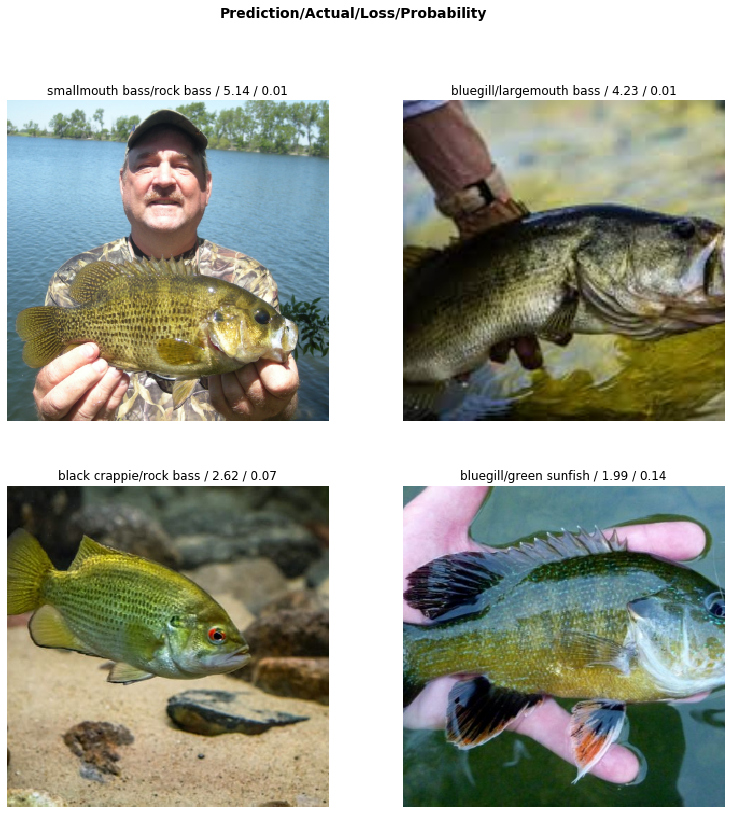

In [17]:
results.plot_top_losses(4, figsize=(13,13))

## Conclusion

We were able to train a basic fish classifier that is about 88% accurate on a training set of 330 images and 11 classes. That's pretty good. At this point we could try gathering more data to train on. This would help to reduce overfitting. We could also explore image localization techniques since the images vary significantly from focusing primarily on the fish to showing significant amounts of background.